# Evaluating infrastructure adaptation options

This notebook forms the basis of "Hands-On 8" in the CCG course.

1. Take the risk results for the Ghana road damage and disruption analysis from previous hands-on sessions
2. Assume some adaptation options - explain what this means - and show their costs
3. Explain cost-benefit analysis (CBA) and show how to calculate Net Present Values for benefits (avoided risks) and costs

By the end of this tutorial you should be able to:
* Quantify the potential risk reduction of adaptation options
* Prioritise assets based on cost-benefit analysis for different adaptation options

In [1]:
# Imports from Python standard library
import math
import os
from pathlib import Path

# Imports from other Python packages
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Change this to point to your data folder as in the previous tutorial:

In [2]:
dir = Path().resolve().parent.parent
data_folder = dir / "ghana_tutorial"
# data_folder = Path("YOUR_PATH/ghana_tutorial")

## 1. Load risk results

Read in regions:

In [3]:
regions = gpd.read_file(
    data_folder / "geoBoundaries-GHA-ADM1-all" / "geoBoundaries-GHA-ADM1.shp"
)[["shapeName", "shapeISO", "geometry"]]

Text(168.1215903043459, 0.5, 'Latitude [deg]')

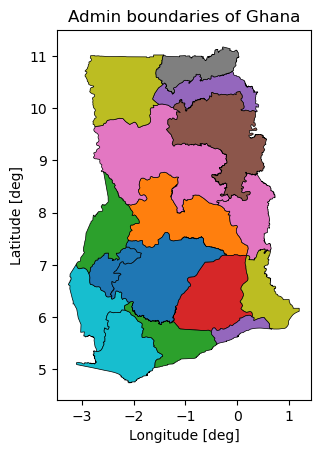

In [4]:
f, ax = plt.subplots(1, 1)

regions.plot(
    ax=ax, alpha=1, linewidth=0.5, column="shapeName", edgecolor="black"
)

ax.set_title("Admin boundaries of Ghana")
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")

Read in roads, join regions:

In [5]:
roads = gpd.read_file(
    data_folder / "GHA_OSM_roads.gpkg", layer="edges"
).rename(columns={"id": "road_id"})
roads = gpd.sjoin(roads, regions).drop(columns="index_right")
roads.head()

,osm_id,road_type,name,road_id,from_id,to_id,length_m,geometry,shapeName,shapeISO
0,4790594,tertiary,Airport Road,roade_0,roadn_0,roadn_1,236.526837,"LINESTRING (-0.17544 5.6055, -0.17418 5.60555,...",Greater Accra Region,GH-AA
1,4790599,tertiary,South Liberation Link,roade_1,roadn_2,roadn_10777,18.539418,"LINESTRING (-0.17889 5.59979, -0.17872 5.59977)",Greater Accra Region,GH-AA
2,4790599,tertiary,South Liberation Link,roade_2,roadn_10777,roadn_3,124.758045,"LINESTRING (-0.17872 5.59977, -0.17786 5.5996,...",Greater Accra Region,GH-AA
3,4790600,tertiary,Airport Road,roade_3,roadn_4,roadn_6313,38.030821,"LINESTRING (-0.1733 5.6056, -0.17327 5.60556, ...",Greater Accra Region,GH-AA
4,4790600,tertiary,Airport Road,roade_4,roadn_6313,roadn_6312,19.532483,"LINESTRING (-0.173 5.60559, -0.17299 5.60561, ...",Greater Accra Region,GH-AA


Read in risk:

In [6]:
risk = pd.read_csv(data_folder / "results" / "inunriver_damages_ead.csv")[
    ["id", "rcp", "gcm", "epoch", "ead_usd"]
].rename(columns={"id": "road_id"})
risk.head()

,road_id,rcp,gcm,epoch,ead_usd
0,roade_10001,historical,WATCH,1980,149980.54647
1,roade_10001,rcp4p5,GFDL-ESM2M,2030,192942.60504
2,roade_10001,rcp4p5,GFDL-ESM2M,2050,192942.60504
3,roade_10001,rcp4p5,GFDL-ESM2M,2080,192942.60504
4,roade_10001,rcp4p5,HadGEM2-ES,2030,192942.60504


In [7]:
exposed_roads = roads[roads.road_id.isin(risk.road_id.unique())]
exposed_roads.head()

,osm_id,road_type,name,road_id,from_id,to_id,length_m,geometry,shapeName,shapeISO
55,4845650,trunk,None,roade_55,roadn_52,roadn_53,256.660267,"LINESTRING (-1.16109 9.14004, -1.15927 9.14149)",Savannah Region,GH-SV
103,11154880,primary,La Road,roade_103,roadn_107,roadn_108,443.190787,"LINESTRING (-0.17564 5.55326, -0.17568 5.55324...",Greater Accra Region,GH-AA
126,11180537,trunk,Winneba Road,roade_126,roadn_131,roadn_9295,522.694931,"LINESTRING (-0.31338 5.55362, -0.31494 5.55356...",Greater Accra Region,GH-AA
127,11180537,trunk,Winneba Road,roade_127,roadn_9295,roadn_9294,54.297481,"LINESTRING (-0.31809 5.55347, -0.31858 5.55345)",Greater Accra Region,GH-AA
128,11180537,trunk,Winneba Road,roade_128,roadn_9294,roadn_9652,1075.851334,"LINESTRING (-0.31858 5.55345, -0.31866 5.55345...",Greater Accra Region,GH-AA


In [8]:
exposure = pd.read_csv(data_folder / "results" / "inunriver_damages_rp.csv")[
    ["id", "length_m", "rcp", "gcm", "epoch", "rp"]
].rename(columns={"id": "road_id", "length_m": "flood_length_m"})

# sum over any segments exposed within the same return period
exposure = exposure.groupby(["road_id", "rcp", "gcm", "epoch", "rp"]).sum()

# pick max length exposed over all return periods
exposure = (
    exposure.reset_index()
    .groupby(["road_id", "rcp", "gcm", "epoch"])
    .max()
    .reset_index()
)

exposure.head()

,road_id,rcp,gcm,epoch,rp,flood_length_m
0,roade_10001,historical,WATCH,1980,1000,414.540523
1,roade_10001,rcp4p5,GFDL-ESM2M,2030,1000,414.540523
2,roade_10001,rcp4p5,GFDL-ESM2M,2050,1000,414.540523
3,roade_10001,rcp4p5,GFDL-ESM2M,2080,1000,414.540523
4,roade_10001,rcp4p5,HadGEM2-ES,2030,1000,414.540523


In [9]:
roads_with_risk = exposed_roads.merge(risk, on="road_id", how="inner").merge(
    exposure, on=["road_id", "rcp", "gcm", "epoch"]
)
roads_with_risk.head()

,osm_id,road_type,name,road_id,from_id,to_id,length_m,geometry,shapeName,shapeISO,rcp,gcm,epoch,ead_usd,rp,flood_length_m
0,4845650,trunk,None,roade_55,roadn_52,roadn_53,256.660267,"LINESTRING (-1.16109 9.14004, -1.15927 9.14149)",Savannah Region,GH-SV,historical,WATCH,1980,378311.530517,1000,256.660267
1,4845650,trunk,None,roade_55,roadn_52,roadn_53,256.660267,"LINESTRING (-1.16109 9.14004, -1.15927 9.14149)",Savannah Region,GH-SV,rcp4p5,GFDL-ESM2M,2030,486679.198955,1000,256.660267
2,4845650,trunk,None,roade_55,roadn_52,roadn_53,256.660267,"LINESTRING (-1.16109 9.14004, -1.15927 9.14149)",Savannah Region,GH-SV,rcp4p5,GFDL-ESM2M,2050,486679.198955,1000,256.660267
3,4845650,trunk,None,roade_55,roadn_52,roadn_53,256.660267,"LINESTRING (-1.16109 9.14004, -1.15927 9.14149)",Savannah Region,GH-SV,rcp4p5,GFDL-ESM2M,2080,486679.198955,1000,256.660267
4,4845650,trunk,None,roade_55,roadn_52,roadn_53,256.660267,"LINESTRING (-1.16109 9.14004, -1.15927 9.14149)",Savannah Region,GH-SV,rcp4p5,HadGEM2-ES,2030,486679.198955,1000,256.660267


## 2. Introduce adaptation options

Introduce costs of road upgrade options.

These costs are taken purely as an example, and further research is required to make reasonable estimates. They are intended to represent upgrade to a bituminous or concrete road design, with a single-lane design for currently-unpaved roads. The routine maintenance costs are estimated for rehabilitation and routine maintenance that should take place every year. The periodic maintenance costs are estimated for resurfacing and surface treatment that may take place approximately every five years.

As before with cost estimates, the analysis is likely to be highly sensitive to these assumptions, which should be replaced by better estimates if available.

In [10]:
options = pd.DataFrame(
    {
        "kind": ["four_lane", "two_lane", "single_lane"],
        "initial_cost_usd_per_km": [1_000_000, 500_000, 125_000],
        "routine_usd_per_km": [20_000, 10_000, 5_000],
        "periodic_usd_per_km": [100_000, 50_000, 25_000],
    }
)
options

,kind,initial_cost_usd_per_km,routine_usd_per_km,periodic_usd_per_km
0,four_lane,1000000,20000,100000
1,two_lane,500000,10000,50000
2,single_lane,125000,5000,25000


Set a discount rate. This will be used to discount the cost of annual and periodic maintenance, as well as the present value of future expected annual damages.

This is another sensitive parameter which will affect the net present value calculations for both costs and benefits. As an exercise, try re-running the remainder of the analysis with different values here. What economic or financial justification could there be for assuming different discount rates?

In [11]:
discount_rate_percentage = 3

Given initial and routine costs and a discount rate, we can calculate the net present value for each adaptation option.

- start by calculating the normalised discount rate for each year over the time horizon
- add the initial costs for each option
- calculate the discounted routine costs for each option (assumed to be incurred each year)
- calculate the discounted periodic costs for each option (assumed to be incurred every five years)

In [12]:
# set up a costs dataframe
costs = pd.DataFrame()

# create a row per year over the time-horizon of interest
costs["year"] = np.arange(2020, 2081)
costs["year_from_start"] = costs.year - 2020

# calculate the normalised discount rate
discount_rate = 1 + discount_rate_percentage / 100
costs["discount_rate_norm"] = costs.year_from_start.apply(
    lambda y: 1.0 / math.pow(discount_rate, y)
)
# calculate the sum over normalised discount rates for the time horizon
# this will be useful later, to calculate NPV of expected damages
discount_rate_norm = costs.discount_rate_norm.sum()

# link each of the options, so we have a row per-option, per-year
costs["link"] = 1
options["link"] = 1
costs = costs.merge(options, on="link").drop(columns="link")

# set initial costs to zero in all years except start year
costs.loc[costs.year_from_start > 0, "initial_cost_usd_per_km"] = 0

# discount routine and periodic maintenance costs
costs.routine_usd_per_km = costs.discount_rate_norm * costs.routine_usd_per_km
costs.periodic_usd_per_km = (
    costs.discount_rate_norm * costs.periodic_usd_per_km
)
# set periodic costs to zero except for every five years
costs.loc[costs.year_from_start == 0, "periodic_usd_per_km"] = 0
costs.loc[costs.year_from_start % 5 != 0, "periodic_usd_per_km"] = 0
costs.head()

,year,year_from_start,discount_rate_norm,kind,initial_cost_usd_per_km,routine_usd_per_km,periodic_usd_per_km
0,2020,0,1.000000,four_lane,1000000,20000.000000,0.0
1,2020,0,1.000000,two_lane,500000,10000.000000,0.0
2,2020,0,1.000000,single_lane,125000,5000.000000,0.0
3,2021,1,0.970874,four_lane,0,19417.475728,0.0
4,2021,1,0.970874,two_lane,0,9708.737864,0.0


This table can then be summarised by summing over all years in the time horizon, to calculate the net present value of all that future investment in maintenance.

In [13]:
npv_costs = (
    costs[
        [
            "kind",
            "initial_cost_usd_per_km",
            "routine_usd_per_km",
            "periodic_usd_per_km",
        ]
    ]
    .groupby("kind")
    .sum()
    .reset_index()
)
npv_costs["total_cost_usd_per_km"] = (
    npv_costs.initial_cost_usd_per_km
    + npv_costs.routine_usd_per_km
    + npv_costs.periodic_usd_per_km
)
npv_costs

,kind,initial_cost_usd_per_km,routine_usd_per_km,periodic_usd_per_km,total_cost_usd_per_km
0,four_lane,1000000,573511.273322,521281.893260,2.094793e+06
1,single_lane,125000,143377.818331,130320.473315,3.986983e+05
2,two_lane,500000,286755.636661,260640.946630,1.047397e+06


## 3. Estimate costs and benefits

Apply road kind assumptions for adaptation upgrades:

In [14]:
def kind(road_type):
    if road_type in ("trunk", "trunk_link", "motorway"):
        return "four_lane"
    elif road_type in ("primary", "primary_link", "secondary"):
        return "two_lane"
    else:
        return "single_lane"


roads_with_risk["kind"] = roads_with_risk.road_type.apply(kind)

Join adaptation cost estimates (per km)

In [15]:
roads_with_costs = roads_with_risk.merge(
    npv_costs[["kind", "total_cost_usd_per_km"]], on="kind"
)

Calculate total cost estimate for length of roads exposed

In [16]:
roads_with_costs["total_adaptation_cost_usd"] = (
    roads_with_costs.total_cost_usd_per_km
    / 1e3
    * roads_with_costs.flood_length_m
)

Calculate net present value of avoided damages over the time horizon:

In [17]:
roads_with_costs["total_adaptation_benefit_usd"] = (
    roads_with_costs.ead_usd * discount_rate_norm
)

In [18]:
discount_rate_norm

np.float64(28.675563666119398)

Calculate benefit-cost ratio

In [19]:
roads_with_costs["bcr"] = (
    roads_with_costs.total_adaptation_benefit_usd
    / roads_with_costs.total_adaptation_cost_usd
)

Filter to pull out just the historical climate scenario:

In [20]:
historical = roads_with_costs[roads_with_costs.rcp == "historical"]
historical.describe()

,length_m,epoch,ead_usd,rp,flood_length_m,total_cost_usd_per_km,total_adaptation_cost_usd,total_adaptation_benefit_usd,bcr
count,2284.000000,2284.0,2.284000e+03,2284.0,2284.000000,2.284000e+03,2.284000e+03,2.284000e+03,2284.000000
mean,3322.402143,1980.0,2.570490e+05,1000.0,1014.678039,1.044815e+06,8.476944e+05,7.371025e+06,7.723680
std,7017.211769,0.0,7.517564e+05,0.0,1939.677219,6.337432e+05,1.706522e+06,2.155704e+07,7.429473
min,1.290015,1980.0,0.000000e+00,1000.0,0.302869,3.986983e+05,1.207532e+02,0.000000e+00,0.000000
25%,45.616752,1980.0,3.272979e+03,1000.0,41.289074,3.986983e+05,4.123917e+04,9.385451e+04,0.635519
50%,350.206822,1980.0,1.939717e+04,1000.0,219.532006,1.047397e+06,1.922925e+05,5.562248e+05,9.905326
75%,3231.311315,1980.0,1.445011e+05,1000.0,967.514059,1.047397e+06,8.193930e+05,4.143652e+06,9.905326
max,73318.605967,1980.0,1.306064e+07,1000.0,17981.326559,2.094793e+06,1.856157e+07,3.745212e+08,20.177240


Filter to find cost-beneficial adaptation options under historic flood scenarios

In [21]:
candidates = historical[historical.bcr > 1]
candidates.head(5)

,osm_id,road_type,name,road_id,from_id,to_id,length_m,geometry,shapeName,shapeISO,...,gcm,epoch,ead_usd,rp,flood_length_m,kind,total_cost_usd_per_km,total_adaptation_cost_usd,total_adaptation_benefit_usd,bcr
0,4845650,trunk,None,roade_55,roadn_52,roadn_53,256.660267,"LINESTRING (-1.16109 9.14004, -1.15927 9.14149)",Savannah Region,GH-SV,...,WATCH,1980,3.783115e+05,1000,256.660267,four_lane,2.094793e+06,5.376502e+05,1.084830e+07,20.17724
62,11180537,trunk,Winneba Road,roade_126,roadn_131,roadn_9295,522.694931,"LINESTRING (-0.31338 5.55362, -0.31494 5.55356...",Greater Accra Region,GH-AA,...,WATCH,1980,7.704407e+05,1000,522.694931,four_lane,2.094793e+06,1.094938e+06,2.209282e+07,20.17724
93,11180537,trunk,Winneba Road,roade_127,roadn_9295,roadn_9294,54.297481,"LINESTRING (-0.31809 5.55347, -0.31858 5.55345)",Greater Accra Region,GH-AA,...,WATCH,1980,8.003328e+04,1000,54.297481,four_lane,2.094793e+06,1.137420e+05,2.294999e+06,20.17724
124,11180537,trunk,Winneba Road,roade_128,roadn_9294,roadn_9652,1075.851334,"LINESTRING (-0.31858 5.55345, -0.31866 5.55345...",Greater Accra Region,GH-AA,...,WATCH,1980,1.585781e+06,1000,1075.851334,four_lane,2.094793e+06,2.253686e+06,4.547316e+07,20.17724
155,11180537,trunk,Winneba Road,roade_129,roadn_9652,roadn_399,185.212407,"LINESTRING (-0.32808 5.55182, -0.32844 5.55168...",Greater Accra Region,GH-AA,...,WATCH,1980,2.729990e+05,1000,185.212407,four_lane,2.094793e+06,3.879817e+05,7.828399e+06,20.17724


Summarise by region to explore where cost-beneficial adaptation options might be located.

We need to sum over exposed lengths of road, costs and benefits, while finding the mean benefit-cost ratio.

In [22]:
candidates.groupby("shapeName").agg(
    {
        "flood_length_m": "sum",
        "total_adaptation_benefit_usd": "sum",
        "total_adaptation_cost_usd": "sum",
        "bcr": "mean",
    }
)

,flood_length_m,total_adaptation_benefit_usd,total_adaptation_cost_usd,bcr
shapeName,,,,
Ahafo Region,6067.892869,5.228802e+07,6.355490e+06,9.100591
Ashanti Region,25487.940983,3.500338e+08,3.152229e+07,11.793901
Bono East Region,26747.750386,4.259800e+08,3.704739e+07,9.620295
Bono Region,7775.671910,5.940093e+07,8.144212e+06,9.515985
Central Region,322983.322696,5.939264e+09,4.246079e+08,15.231698
Eastern Region,110905.979464,1.337603e+09,1.336097e+08,10.940803
Greater Accra Region,111256.006723,2.343292e+09,1.653372e+08,13.150013
North East Region,24347.114853,1.978790e+08,2.743855e+07,10.198693
Northern Region,29609.573003,2.888411e+08,3.390784e+07,12.310590


Given the aggregation, filtering and plotting you've seen throughout these tutorials, what other statistics would be interesting to explore from these results?